# Hidden Markov Models

In this notebook, we will demonstrate how to fit Hidden Markov Models (HMMs) using StateSpaceDynamics.jl. HMMs are a fundamental class of probabilistic models used to infer hidden (latent) states from observed data. They have broad applications in fields such as computational biology, neuroscience, finance, and speech recognition.

By modeling sequential data with an underlying discrete state structure, HMMs provide a powerful framework for uncovering temporal patterns, classifying time series, and making probabilistic predictions. Moreover, they serve as a foundation for more advanced state-space models, such as switching regression models (HMM-GLMs) and switching linear dynamical systems (sLDS), which introduce additional flexibility for modeling continuous data with state-dependent dynamics.

This tutorial will guide you through:

    1. Defining and initializing an HMM
    2. Simulating data from an HMM with known parameters
    3. Estimating HMM parameters from observed sequences using Expectation-Maximization
    4. Evaluating HMM training fit
    4. Performing state inference using the Viterbi algorithm and the forward-backward algorithm

For theoretical background, refer to Chapter 13 of Pattern Recognition and Machine Learning by Christopher Bishop. Let's get started!

# Setup

In [14]:
# Import the relevant packages
using LinearAlgebra
using Plots
using Random
using StateSpaceDynamics

# For convenience
const SSD = StateSpaceDynamics

StateSpaceDynamics

# Initializing a Gaussian HMM

In [15]:
# Define the output dimensionality of the HMM
output_dim = 2

# Define the transition matrix and the initial state distribution
A = [0.99 0.01; 0.05 0.95];
πₖ = [0.5; 0.5]

# Initialize the emission models
μ_1 = [0.0, 0.0]
Σ_1 = 0.1 * Matrix{Float64}(I, output_dim, output_dim)
emission_1 = GaussianEmission(output_dim, μ_1, Σ_1)

μ_2 = [2.0, 1.0]
Σ_2 = 0.2 * Matrix{Float64}(I, output_dim, output_dim)
emission_2 = GaussianEmission(output_dim, μ_2, Σ_2)

# The general HMM constructor is used as follows
model = HiddenMarkovModel(K=2, B=[emission_1, emission_2], A=A, πₖ=πₖ)

# One could instead use the GaussianHMM wrapper and plug in the emission models afterwards
model = GaussianHMM(K=2, output_dim=2, A=A, πₖ=πₖ)
model.B[1], model.B[2] = emission_1, emission_2


(GaussianEmission{Float64, Vector{Float64}, Matrix{Float64}}(2, [0.0, 0.0], [0.1 0.0; 0.0 0.1]), GaussianEmission{Float64, Vector{Float64}, Matrix{Float64}}(2, [2.0, 1.0], [0.2 0.0; 0.0 0.2]))

# Sampling from an HMM

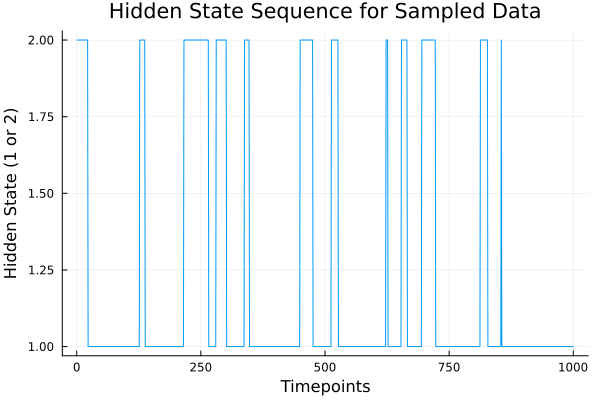

In [16]:
# Define number of samples to generate 
n=10000

# Use the SSD sampling function and store the hidden states and emission data
true_labels, data = SSD.sample(model, n=n)

plot(true_labels[1:1000], label=false)
title!("Hidden State Sequence for Sampled Data")
ylabel!("Hidden State (1 or 2)")
xlabel!("Timepoints")

# Fitting an HMM to data

Recovered Emission 1?: true
Recovered Emission 2?: true


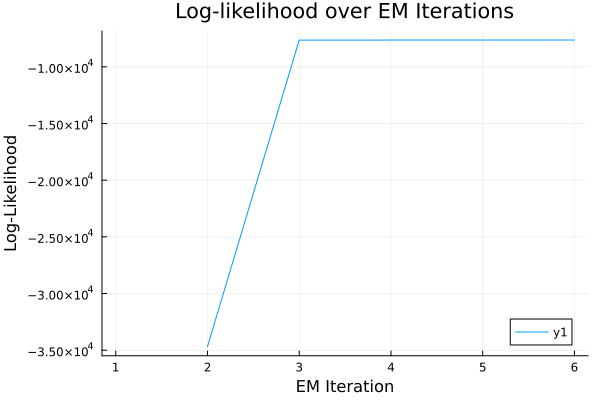

In [17]:
# Initialize a new GaussianHMM
test_model = GaussianHMM(K=2, output_dim=2)
test_model.A = [0.8 0.2; 0.05 0.95]
test_model.πₖ = [0.6; 0.4]

μ_1 = [0.5, -0.5]
Σ_1 = 0.1 * Matrix{Float64}(I, output_dim, output_dim)
emission_1 = GaussianEmission(output_dim, μ_1, Σ_1)

μ_2 = [3.0, 0.75]
Σ_2 = 0.2 * Matrix{Float64}(I, output_dim, output_dim)
emission_2 = GaussianEmission(output_dim, μ_2, Σ_2)

test_model.B[1] = emission_1
test_model.B[2] = emission_2

# Fit the HMM to the data using the SSD fit!() function
lls = fit!(test_model, data)

# Show that we can properly recover the true parameters
println("Recovered Emission 1?: ", isapprox(test_model.B[1].μ, model.B[1].μ, atol=0.1) || isapprox(test_model.B[1].μ, model.B[2].μ, atol=0.1))
println("Recovered Emission 2?: ",isapprox(test_model.B[2].μ, model.B[2].μ, atol=0.1) || isapprox(test_model.B[2].μ, model.B[1].μ, atol=0.1))

plot(lls)
title!("Log-likelihood over EM Iterations")
xlabel!("EM Iteration")
ylabel!("Log-Likelihood")

# Visualizing State Predictions

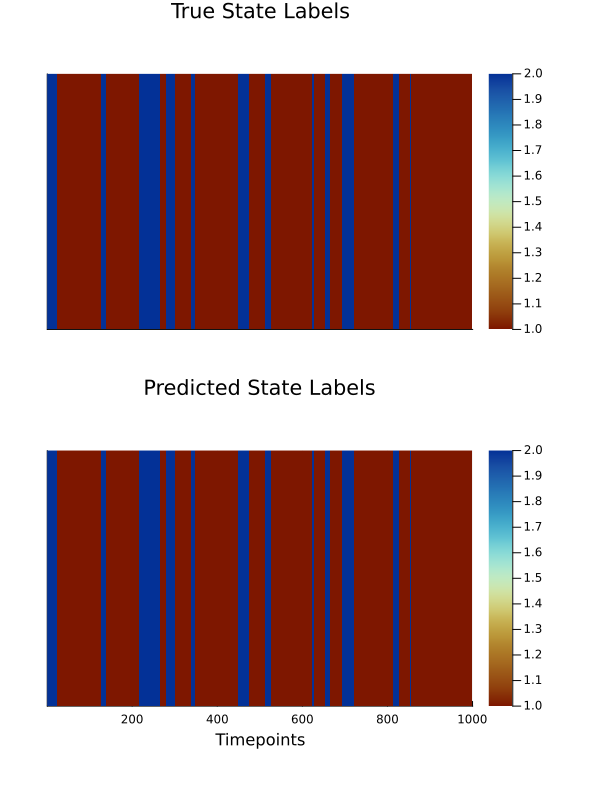

In [18]:
# Plot hidden state decoding from fit model vs. true state labels
pred_labels= viterbi(test_model, data);

# Additionally we can use the following function to get probabilities rather than most likely state labels
state_probabilities = class_probabilities(test_model, data);

# Create heatmaps
p1 = heatmap(true_labels[1:1000]', colormap=:roma50, title="True State Labels", xlabel="", ylabel="", xticks=false, yticks=false)
p2 = heatmap(pred_labels[1:1000]', colormap=:roma50, title="Predicted State Labels", xlabel="Timepoints", ylabel="", xticks=true, yticks=false)

# Combine into subplots
plot(p1, p2, layout=(2, 1), size=(600, 800), margin=10Plots.mm)

# Data with multiple Trials

It is common to collect many trials of data in neuroscience experiments. To accurately estimate the the HMM parameters for multiple trials of data simply create a vector of matrices that contain single trials of data. We demonstrate this functionality below.

Running EM algorithm... 100%|██████████████████████████████████████████████████| Time: 0:00:01 (18.34 ms/it)


Recovered Emission 1?: true
Recovered Emission 2?: true


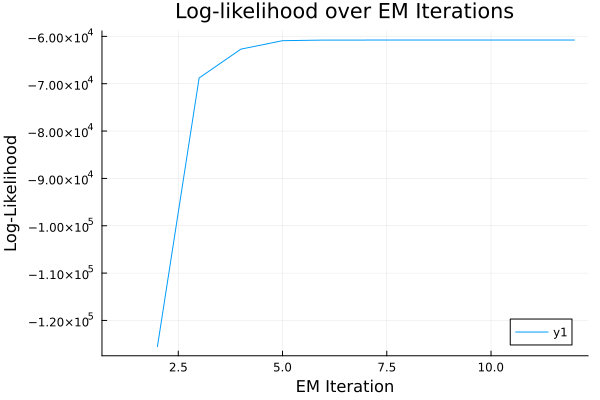

In [19]:
"""
The emission model and HMM initialization remain the same as before.
"""

# Create Guassian Emission Models
output_dim = 2
μ = [0.0, 0.0]
Σ = 0.1 * Matrix{Float64}(I, output_dim, output_dim)
emission_1 = GaussianEmission(output_dim, μ, Σ)

output_dim = 2
μ = [0.0, 1.0]
Σ = 0.1 * Matrix{Float64}(I, output_dim, output_dim)
emission_2 = GaussianEmission(output_dim, μ, Σ)

# Create GaussianHMM
true_model = SSD.GaussianHMM(K=2, output_dim=2)
true_model.B[1] = emission_1
true_model.B[2] = emission_2
true_model.A = [0.99 0.01; 0.05 0.95]

"""
Here, we sample multiple trials of data by looping over our sample function.
"""
# Number of trials and samples per trial
n_trials = 100
n_samples = 1000

# Preallocate storage for true_labels and data from each trial
all_true_labels = Vector{Vector{Int}}(undef, n_trials)
all_data = Vector{Matrix{Float64}}(undef, n_trials)

# Run 100 sampling trials
for i in 1:n_trials
    true_labels, data = SSD.sample(true_model, n=n_samples)
    all_true_labels[i] = true_labels
    all_data[i] = data
end

"""
Finally, we demonstrate that our fit function can handle multiple trials when the data is organized as a Vector{<:Matrix{Float64}}
"""
# Fit a gaussian hmm to the data
test_model = SSD.GaussianHMM(K=2, output_dim=2)
test_model.A = [0.8 0.2; 0.3 0.7]

# Create Guassian Emission Models
output_dim = 2
μ = [-0.2, 0.15]
Σ = 0.1 * Matrix{Float64}(I, output_dim, output_dim)
emission_1 = GaussianEmission(output_dim, μ, Σ)

output_dim = 2
μ = [-0.25, 0.50]
Σ = 0.1 * Matrix{Float64}(I, output_dim, output_dim)
emission_2 = GaussianEmission(output_dim, μ, Σ)

test_model.B[1] = emission_1
test_model.B[2] = emission_2

lls = SSD.fit!(test_model, all_data)

# Show that we can properly recover the true parameters
println("Recovered Emission 1?: ", isapprox(test_model.B[1].μ, true_model.B[1].μ, atol=0.1) || isapprox(test_model.B[1].μ, true_model.B[2].μ, atol=0.1))
println("Recovered Emission 2?: ",isapprox(test_model.B[2].μ, true_model.B[2].μ, atol=0.1) || isapprox(test_model.B[2].μ, true_model.B[1].μ, atol=0.1))

plot(lls[1:end])
title!("Log-likelihood over EM Iterations")
xlabel!("EM Iteration")
ylabel!("Log-Likelihood")


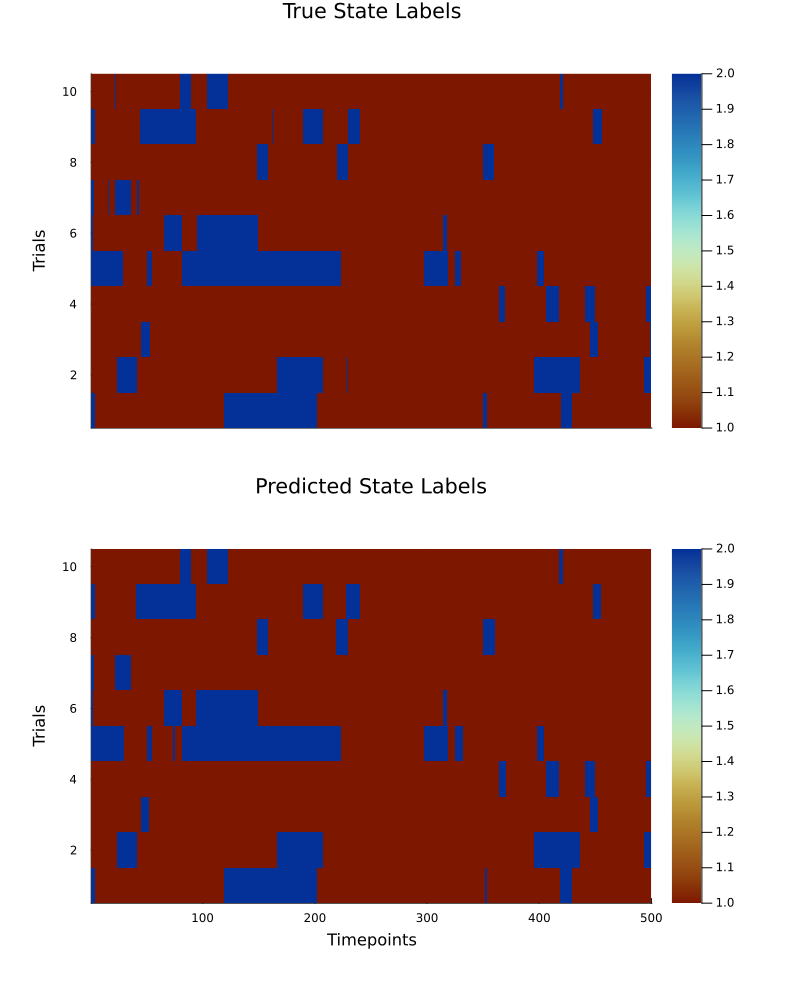

In [20]:
"""
Heatmaps of state labels
"""

# Preallocate storage for predicted labels
all_pred_labels = Matrix{Int}(undef, n_trials, n_samples)

# Compute predicted state labels for each trial
for i in 1:n_trials
    all_pred_labels[i, :] = viterbi(test_model, all_data[i])  # Decode hidden states
end

# Stack true labels into a matrix for heatmap plotting
all_true_labels_matrix = hcat(all_true_labels...)'

# Create heatmaps for multiple trials
p1 = heatmap(all_true_labels_matrix[1:10, 1:500], colormap=:roma50, title="True State Labels", xlabel="", ylabel="Trials", xticks=false, yticks=true)
p2 = heatmap(all_pred_labels[1:10, 1:500], colormap=:roma50, title="Predicted State Labels", xlabel="Timepoints", ylabel="Trials", xticks=true, yticks=true)

# Combine into subplots
plot(
    p1, p2, 
    layout=(2, 1), 
    size=(800, 1000), 
    margin=10Plots.mm
)
